In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Read data

In [2]:
with open("dialog_acts.dat", 'r') as file:
    data = {'label': [], 'sentence': [], 'prediction': []}
    
    for line in file:
        words = line.split(maxsplit=1)
        if len(words) > 1:
            data['label'].append(words[0])
            data['sentence'].append(words[1])
        else:
            data['label'].append(words[0])
            data['sentence'].append('')

# inform Baseline

In [3]:
for sentence in data["sentence"]:
    data["prediction"].append("inform")

In [4]:
if len(data['label']) != len(data['prediction']):
    print("Error: The number of labels and predictions do not match.")
else:
    correct = 0
    total = len(data['label'])

    for i in range(total):
        if data['label'][i] == data['prediction'][i]:
            correct += 1

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 39.84%


# Rule based baseline

In [5]:
def count_labels(data):
    label_counts = {}

    # Count the occurrences of each label
    for label in data['label']:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Print the count of each label
    for label, count in label_counts.items():
        print(f"{label}: {count}")

In [6]:
count_labels(data)

inform: 10160
confirm: 172
affirm: 1156
request: 6494
thankyou: 3259
null: 1612
bye: 266
reqalts: 1747
negate: 435
hello: 93
repeat: 33
ack: 28
restart: 14
deny: 27
reqmore: 5


In [7]:
keywords = {
    'ack': ['kay', 'okay'],
    'affirm': ['yes', 'right', 'yeah'],
    'thankyou': ['thank'],
    'bye': ['bye', 'goodbye'],
    'confirm': ['is it', 'does it', 'do they'],
    'deny': ['wrong', 'dont', 'not'],
    'hello': ['hi', 'hello', 'halo', 'welcome'],
    'inform': [
        'looking', 'restaurant', 'any', 'food', 'part', 'town', 'cheap', 'expensive', 
        'mediterranean', 'seafood', 'east', 'west', 'north', 'south', 'asian', 
        'oriental', 'scottish', 'matter', 'european', 'want', 'care', 'austrian', 
        'center', 'corsica', 'international', 'priced', 'moderately', 'moderate', 
        'central', 'eirtrean', 'spanish', 'venue', 'australian', 'turkish'
    ],
    'negate': ['no'],
    'null': [],
    'repeat': ['repeat', 'again', 'back'],
    'reqalts': ['how about', 'what about', 'is there', 'anything else'],
    'reqmore': ['more'],
    'request': ['address', 'phone', 'number', 'post code', 'how much', 'where', 'whats', 'what is', 'price range'],
    'restart': ['start', 'reset'],
}

In [8]:
def classify_sentence(sentence, keywords):
    # Convert the sentence to lowercase
    sentence_lower = sentence.lower()
    
    # Sort keywords by length in descending order to match longer phrases first
    sorted_keywords = sorted(((label, keyword) for label, kw_list in keywords.items() for keyword in kw_list),
                              key=lambda x: len(x[1]), reverse=True)
    
    # Check if any keyword is in the sentence
    for label, keyword in sorted_keywords:
        if keyword in sentence_lower:
            return label
    
    # Return 'null' if no keywords are found
    return 'null'

In [9]:
data['prediction'] = [classify_sentence(sentence, keywords) for sentence in data['sentence']]

In [10]:
def calculate_accuracy_filtered(labels, predictions):
    filtered_labels = []
    filtered_predictions = []
    
    for label, prediction in zip(labels, predictions):
        filtered_labels.append(label)
        filtered_predictions.append(prediction)
    
    if len(filtered_labels) != len(filtered_predictions):
        raise ValueError("Filtered labels and predictions lists must be of the same length.")
    
    correct = sum(1 for l, p in zip(filtered_labels, filtered_predictions) if l == p)
    total = len(filtered_labels)
    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

accuracy = calculate_accuracy_filtered(data['label'], data['prediction'])
print(accuracy)

81.48307909493745


In [11]:
from collections import defaultdict

def calculate_accuracy_per_label(labels, predictions):
    label_counts = defaultdict(int)  # To count occurrences of each label
    correct_counts = defaultdict(int)  # To count correct predictions for each label

    for label, prediction in zip(labels, predictions):
        label_counts[label] += 1
        if label == prediction:
            correct_counts[label] += 1

    accuracy_per_label = {}
    for label in label_counts:
        total = label_counts[label]
        correct = correct_counts[label]
        accuracy_per_label[label] = (correct / total) * 100 if total > 0 else 0
    
    return accuracy_per_label

accuracy_per_label = calculate_accuracy_per_label(data['label'], data['prediction'])

# Print or inspect the accuracy per label
for label, accuracy in accuracy_per_label.items():
    print(f"{label}, Accuracy: {accuracy:.2f}%")


inform, Accuracy: 79.60%
confirm, Accuracy: 51.16%
affirm, Accuracy: 80.62%
request, Accuracy: 88.10%
thankyou, Accuracy: 87.11%
null, Accuracy: 61.29%
bye, Accuracy: 74.44%
reqalts, Accuracy: 85.00%
negate, Accuracy: 70.11%
hello, Accuracy: 49.46%
repeat, Accuracy: 100.00%
ack, Accuracy: 60.71%
restart, Accuracy: 92.86%
deny, Accuracy: 81.48%
reqmore, Accuracy: 100.00%


In [12]:
def classify_sentence(sentence):
    for label, words in keywords.items():
        if any(word in sentence.lower() for word in words):
            return label
    return 'Unknown'  # Default label if no keywords are matched

In [43]:
def manual_test_model(classify_function):
    while True:
        sentence = input("Enter a sentence to classify (or type 'exit' to stop): ")
        
        if sentence.lower() == 'exit':
            print("Exiting the classifier.")
            break
        
        label = classify_function(sentence)
        print(f"Classified as: {label}")

In [45]:
manual_test_model(classify_sentence)

Enter a sentence to classify (or type 'exit' to stop):  exit


Exiting the classifier.


# Feed Forward Neural Network

In [15]:
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [16]:
# Convert all labels to numbers
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [17]:
max_words = 10000  # Maximum number of words
max_len = 128  # Maximum sentence length

In [18]:
# Tokenize all words
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['sentence'])
sequences = tokenizer.texts_to_sequences(data['sentence'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [19]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    padded_sequences, data['label'], test_size=0.2, random_state=42
)

In [20]:
def create_model():
    model = models.Sequential()
    
    model.add(layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(15, activation='softmax'))  # 15 classes
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          1280000   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 5478415 (20.90 MB)
Trainable params: 5478415 (20.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(train_sentences, train_labels, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5


1020/1020 [==============================] - 32s 31ms/step - loss: 0.2849 - accuracy: 0.9206 - val_loss: 0.0927 - val_accuracy: 0.9745
Epoch 2/5
1020/1020 [==============================] - 31s 31ms/step - loss: 0.0678 - accuracy: 0.9816 - val_loss: 0.0900 - val_accuracy: 0.9757
Epoch 3/5
1020/1020 [==============================] - 31s 30ms/step - loss: 0.0374 - accuracy: 0.9890 - val_loss: 0.0836 - val_accuracy: 0.9794
Epoch 4/5
1020/1020 [==============================] - 32s 31ms/step - loss: 0.0281 - accuracy: 0.9907 - val_loss: 0.0843 - val_accuracy: 0.9782
Epoch 5/5
1020/1020 [==============================] - 32s 32ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0927 - val_accuracy: 0.9804


In [31]:
def model_report(model, sentences):
    # Make predictions on the test set
    predictions = model.predict(test_sentences)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Ensure all 15 classes are included in the report
    all_classes = list(range(15))
    
    # Generate the classification report
    report = classification_report(test_labels, predicted_labels, labels=all_classes, target_names=[f'{le.inverse_transform([i])[0]}' for i in all_classes])
    
    print(report)

In [32]:
model_report(model, test_sentences)

160/160 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         ack       0.50      0.20      0.29         5
      affirm       1.00      0.98      0.99       247
         bye       0.90      0.98      0.94        46
     confirm       0.89      0.94      0.91        33
        deny       1.00      0.71      0.83         7
       hello       1.00      1.00      1.00        16
      inform       0.99      0.98      0.99      2041
      negate       1.00      0.99      0.99        81
        null       0.92      0.99      0.96       309
      repeat       1.00      0.75      0.86         4
     reqalts       0.97      0.95      0.96       368
     reqmore       1.00      1.00      1.00         2
     request       1.00      1.00      1.00      1305
     restart       1.00      1.00      1.00         3
    thankyou       1.00      0.99      0.99       634

    accuracy                           0.99      5101
   macro avg       0.94  

In [40]:
def confusion_matrix(sentences, labels):
    # Get the predictions for the test set
    y_pred = model.predict(sentences)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels
    
    # Use test_labels directly if they are not one-hot encoded
    y_true_labels = labels
    
    # Generate confusion matrix
    cm = sklearn_confusion_matrix(y_true_labels, y_pred_labels)
    
    # Get the actual class names (the inverse transform from LabelEncoder)
    class_names = le.inverse_transform(np.unique(y_true_labels))
    
    # Plot the confusion matrix with actual labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

160/160 [==============================] - 0s 2ms/step


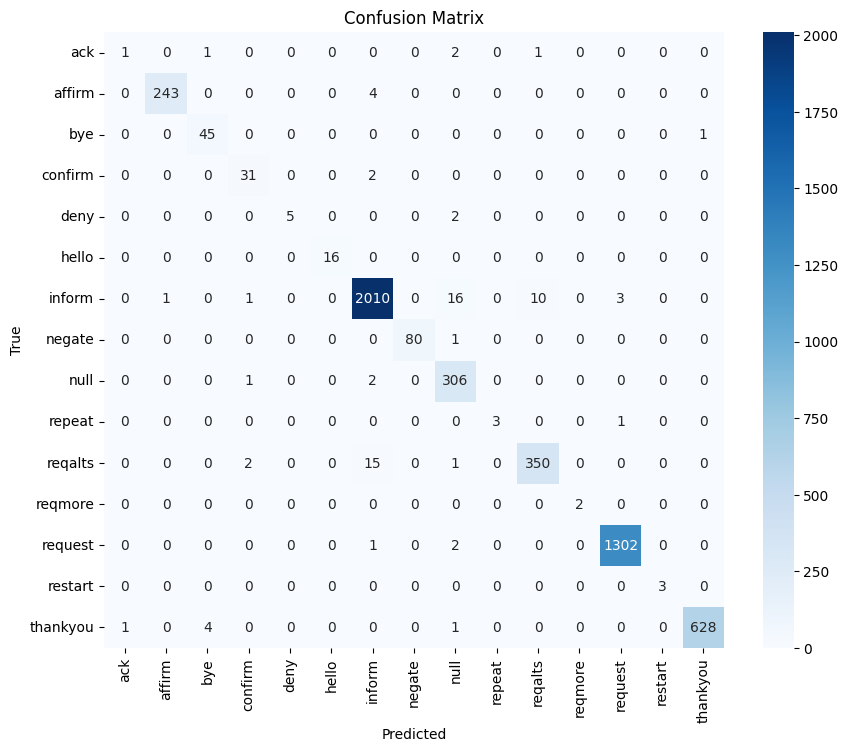

In [41]:
confusion_matrix(test_sentences, test_labels)

In [26]:
test_loss, test_acc = model.evaluate(test_sentences, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9819 - loss: 0.0796
Test Accuracy: 98.08%


In [27]:
unique_labels = sorted(list(set(data['label'])))

In [28]:
def classify_sentence_fnn(sentence):
    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=128, padding='post')
    
    # Get prediction from the model
    prediction = model.predict(padded_sequence)
    
    # Get the index of the highest probability
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = le.inverse_transform([predicted_label_index])[0]

    return predicted_label

In [ ]:
manual_test_model(classify_sentence_fnn)

Enter a sentence to classify (or type 'exit' to stop): Where can i find a restaurant in the centre?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Classified as: request
Enter a sentence to classify (or type 'exit' to stop): Hi, where can i find good place for food?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classified as: request
Enter a sentence to classify (or type 'exit' to stop): Hello! Where can i find food?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classified as: hello
Enter a sentence to classify (or type 'exit' to stop): Hello! Where can i find a place to eat?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classified as: hello
Enter a sentence to classify (or type 'exit' to stop): Thankyou, and where can i repair my phone?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Classified as: request
Enter a sentence to classify (or type 'exit' to stop): Thankyou, and how about Paris?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Classified as: reqalts
Enter a sentence to classify (or type 'exit' to stop): Thankyou, But can you 

### Deduplicate

In [ ]:
df = pd.DataFrame(data)
df_cleaned = df.drop_duplicates(subset=['label', 'sentence'])
data_deduplicate = df_cleaned.to_dict(orient='list')
data_deduplicate['label'] = np.array(data_deduplicate['label'])

In [ ]:
# Convert all labels to numbers
le_dedup = LabelEncoder()
data_deduplicate['label'] = le_dedup.fit_transform(data_deduplicate['label'])

In [ ]:
print(len(data['sentence']))
print(len(data_deduplicate['sentence']))

In [ ]:
# Tokenize all words
tokenizer_dedup = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer_dedup.fit_on_texts(data_deduplicate['sentence'])
sequences_dedup = tokenizer_dedup.texts_to_sequences(data_deduplicate['sentence'])
padded_sequences_dedup = pad_sequences(sequences_dedup, maxlen=max_len, padding='post')

In [ ]:
train_sentences_dedup, test_sentences_dedup, train_labels_dedup, test_labels_dedup = train_test_split(
    padded_sequences_dedup, data_deduplicate['label'], test_size=0.2, random_state=42
)

In [ ]:
model_deduplicate = create_model()
history_deduplicate = model_deduplicate.fit(train_sentences_dedup, train_labels_dedup, epochs=5, batch_size=16, validation_split=0.2)

In [ ]:
test_loss_deduplicate, test_acc_deduplicate = model_deduplicate.evaluate(test_sentences_dedup, test_labels_dedup)
print(f"Test Accuracy: {test_acc_deduplicate * 100:.2f}%")

In [ ]:
model_report(model_deduplicate, test_sentences_dedup)

In [ ]:
confusion_matrix(test_sentences_dedup, test_labels_dedup, le)

# Decision tree

In [46]:
# imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report